In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, f_oneway, pearsonr
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
import calendar
import datetime
import statsmodels.api as sm
import copy

In [2]:
storeData = pd.read_csv('./store.csv',dtype = {'7':np.int32})
storeData

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [3]:
#checking for null values
storeData.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [4]:
storeData['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [5]:
# % of Nan values 
print(storeData.isnull().sum() / storeData.count()*100)

print("% Missing Data",storeData.isnull().sum().sum() / storeData.count().sum())


Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269784
CompetitionOpenSinceMonth    46.517740
CompetitionOpenSinceYear     46.517740
Promo2                        0.000000
Promo2SinceWeek              95.271454
Promo2SinceYear              95.271454
PromoInterval                95.271454
dtype: float64
% Missing Data 0.2660383785625071


In [6]:
# number of stores participating in promo2 

storeData['Promo2'][storeData['Promo2']==1].count() / 1115 *100

51.210762331838566

In [7]:
#looking at missing values data to detemine if missing values are linked to a type of store

missingvals = storeData[['StoreType','CompetitionDistance','CompetitionOpenSinceMonth']][storeData['CompetitionOpenSinceMonth'].isnull()]

missingvals['CompetitionOpenSinceMonth'] = missingvals['CompetitionOpenSinceMonth'].fillna(1)

missingvals.groupby(['StoreType']).agg({'CompetitionDistance':['mean','min','max'],
                                       'CompetitionOpenSinceMonth':'sum'}).round(0)

CompetitionDistance                 CompetitionOpenSinceMonth
                         mean    min      max                       sum
StoreType                                                              
a                      5501.0   20.0  75860.0                     176.0
b                      1114.0   90.0   3640.0                       8.0
c                      2768.0  110.0  19640.0                      41.0
d                      6466.0  150.0  22560.0                     129.0

In [8]:
#looking at which stores don't have competition distance data.
storeData[storeData['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [9]:
mean_comp_distance = storeData.groupby('StoreType')['CompetitionDistance'].mean()

In [10]:
#impute missing values with mean of store distances
storeData['CompetitionDistance'] = storeData['CompetitionDistance'].fillna(0)
for index, row in storeData.iterrows():
    x_value = storeData['CompetitionDistance'][index] 
    mean = mean_comp_distance[storeData['StoreType'][index]]
    if storeData['CompetitionDistance'][index]==0:
        x_value = mean
    else:
        x_value

In [11]:
#checking for null values
storeData.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
#imputing zero for all promo rows which are not participating in promotions
#used this method rather then fillna to be sure columns were consistent
for index, row in storeData.iterrows():
    if row['Promo2'] == 0:
        storeData.iloc[index,7:10] = 0

In [13]:
#checking for null values
storeData.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [14]:
#Changing competitionopensincemonth and competitionopensinceyear and day as the first of the month
storeData['Datetime_Comp'] = pd.to_datetime(storeData.rename(columns={'CompetitionOpenSinceMonth':'Month','CompetitionOpenSinceYear':'Year'})[['Month','Year']].assign(DAY=1))

In [15]:
#converting promototionsinceweek and promotionsinceyear to datatime, day value was assumed to be the monday of the given week.


Promo_Datetime = []
for index, row in storeData.iterrows():
    if storeData['Promo2'][index] != 0: 
        x = str(int(storeData['Promo2SinceYear'][index])) +'-W'+ str(int(storeData['Promo2SinceWeek'][index]))
        Promo_Datetime.append(datetime.datetime.strptime(x + '-1',"%Y-W%W-%w"))
    else:
        Promo_Datetime.append(np.NaN)

        
#add new column
storeData['Promo_Datetime'] = Promo_Datetime
storeData

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Datetime_Comp,Promo_Datetime
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,NaT
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-04
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,NaT
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2014-06-01,2013-08-05
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,2006-04-01,NaT
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,0,NaT,NaT
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,0,NaT,NaT


In [16]:
#dropping old columns
storeData = storeData.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'],axis=1)

In [17]:
storeData.isnull().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
PromoInterval            0
Datetime_Comp          354
Promo_Datetime         544
dtype: int64

In [18]:
storeData.isnull().sum().sum()/ storeData.size *100

10.067264573991032

In [19]:
#converting promointerval into 4 separate columns
promo2month_data = pd.DataFrame(storeData['PromoInterval'].str.split(',',4,expand=True))

#replacing months with corresponding numbers for comparison to dates in traindata
promo2month_data = promo2month_data.replace({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12})

#join data 
storeData = pd.concat([storeData, promo2month_data], axis=1, join="inner")
storeData

,Store,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Datetime_Comp,Promo_Datetime,0,1,2,3
0,1,c,a,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN
1,2,a,a,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0
2,3,a,a,14130.0,1,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-04,1.0,4.0,7.0,10.0
3,4,c,c,620.0,0,0,2009-09-01,NaT,NaN,NaN,NaN,NaN
4,5,a,a,29910.0,0,0,2015-04-01,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,1,"Jan,Apr,Jul,Oct",2014-06-01,2013-08-05,1.0,4.0,7.0,10.0
1111,1112,c,c,1880.0,0,0,2006-04-01,NaT,NaN,NaN,NaN,NaN
1112,1113,a,c,9260.0,0,0,NaT,NaT,NaN,NaN,NaN,NaN
1113,1114,a,c,870.0,0,0,NaT,NaT,NaN,NaN,NaN,NaN


In [20]:
trainData = pd.read_csv('./train.csv', dtype = {'7':str})
trainData['Date'] = pd.to_datetime(trainData['Date'])

/home/elia/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
trainData.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [22]:
trainData['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [23]:
#merging tables on store number
traindata_merge = trainData.merge(storeData, how = 'inner', on = 'Store')

#creating Date Month column consisting of the month only to see if the store was participating in promo2 in a given month
traindata_merge['Date_Month'] = pd.DatetimeIndex(traindata_merge['Date']).month

In [24]:
traindata_merge.isnull().sum()

Store                       0
DayOfWeek                   0
Date                        0
Sales                       0
Customers                   0
Open                        0
Promo                       0
StateHoliday                0
SchoolHoliday               0
StoreType                   0
Assortment                  0
CompetitionDistance         0
Promo2                      0
PromoInterval               0
Datetime_Comp          323348
Promo_Datetime         508031
0                      508031
1                      508031
2                      508031
3                      508031
Date_Month                  0
dtype: int64

In [25]:
#updating promo2 column to show weather store was participating in Promo2 on a given day
m = (traindata_merge[0] == traindata_merge['Date_Month'])
m1 = (traindata_merge[1] == traindata_merge['Date_Month'])
m2 = (traindata_merge[2] == traindata_merge['Date_Month'])
m3 = (traindata_merge[3] == traindata_merge['Date_Month'])
traindata_merge['Promo2'] = np.select([m,m1,m2,m3],[1,1,1,1],default=0)
traindata_merge

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,Promo2,PromoInterval,Datetime_Comp,Promo_Datetime,0,1,2,3,Date_Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,7
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,7
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,7
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,7
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-05-01,4771,339,1,0,0,1,d,...,5350.0,0,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,5
1017205,1115,5,2013-04-01,4540,326,1,0,0,1,d,...,5350.0,0,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,4
1017206,1115,4,2013-03-01,4297,300,1,0,0,1,d,...,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,3
1017207,1115,3,2013-02-01,3697,305,1,0,0,1,d,...,5350.0,0,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,2


In [26]:
#checking consistency
traindata_merge[traindata_merge['Promo2'] == 1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,Promo2,PromoInterval,Datetime_Comp,Promo_Datetime,0,1,2,3,Date_Month
942,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0,7
943,2,4,2015-07-30,5567,601,1,1,0,1,a,...,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0,7
944,2,3,2015-07-29,6402,727,1,1,0,1,a,...,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0,7
945,2,2,2015-07-28,5671,646,1,1,0,1,a,...,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0,7
946,2,1,2015-07-27,6627,638,1,1,0,1,a,...,570.0,1,"Jan,Apr,Jul,Oct",2007-11-01,2010-03-29,1.0,4.0,7.0,10.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017175,1115,7,2013-03-02,0,0,0,0,0,0,d,...,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,3
1017197,1115,6,2013-12-01,4497,350,1,0,0,0,d,...,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,12
1017200,1115,3,2013-09-01,4649,324,1,1,0,1,d,...,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,9
1017203,1115,7,2013-06-01,0,0,0,0,0,1,d,...,5350.0,1,"Mar,Jun,Sept,Dec",NaT,2012-05-28,3.0,6.0,9.0,12.0,6


In [27]:
#calculating how long since stores competition opened and started promotions
traindata_merge['TimeSinceCompetitionOpening'] = traindata_merge['Date'] - traindata_merge['Datetime_Comp']
traindata_merge['TimeSincePromoStart'] = traindata_merge['Date'] - traindata_merge['Promo_Datetime']

#converting into days as integer
traindata_merge['TimeSinceCompetitionOpening'] = traindata_merge['TimeSinceCompetitionOpening'].dt.days
traindata_merge['TimeSincePromoStart'] = traindata_merge['TimeSincePromoStart'].dt.days

In [28]:
promo1_only = traindata_merge[(traindata_merge['Promo2'] == 1) & (traindata_merge['Open']==1)]

competition_vs_sales = traindata_merge[(~traindata_merge['TimeSinceCompetitionOpening'].isnull()) & (traindata_merge['Open']==1)]


(-0.012230499768850715, 1.682196576913892e-20)

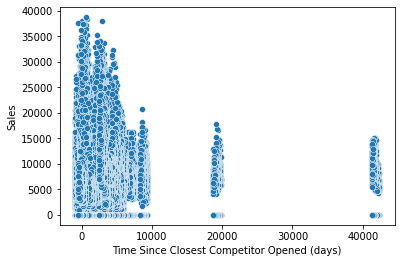

In [29]:
#checking correlation between time since competition opening
sns.scatterplot(data=traindata_merge, x='TimeSinceCompetitionOpening', y='Sales')

plt.xlabel('Time Since Closest Competitor Opened (days)')

pearsonr(competition_vs_sales['TimeSinceCompetitionOpening'],competition_vs_sales['Sales'])

(0.031352601149982506, 1.780450140500272e-32)

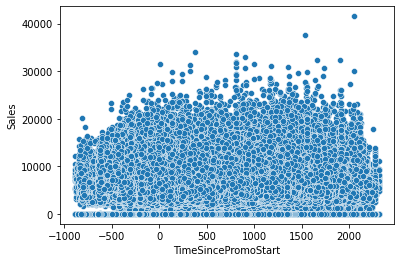

In [30]:
#checking corrlation between time since promotion start and sales
sns.scatterplot(data=traindata_merge, x='TimeSincePromoStart', y='Sales')
pearsonr(promo1_only['TimeSincePromoStart'],promo1_only['Sales'])

In [31]:
#dropping unneccessary columns
traindata_merge = traindata_merge.drop(['Datetime_Comp','Promo_Datetime','Datetime_Comp','Date_Month',0,1,2,3,'Promo_Datetime','TimeSincePromoStart','TimeSinceCompetitionOpening'],axis=1)

In [32]:
#checking for no NaN
traindata_merge.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
PromoInterval          0
dtype: int64

Exploratory Data Analysis

In [33]:
timeseries = traindata_merge.copy()

In [34]:
timeseries['Month'] = pd.DatetimeIndex(timeseries['Date']).month
timeseries['Year'] = pd.DatetimeIndex(timeseries['Date']).year

In [35]:
#get only data from complete years 
timeseries = timeseries[timeseries['Year'].isin([2013,2014])]

In [36]:
#making time series for trend analysis and seasonal decomposition

ts = timeseries.groupby(['Year','Month'])['Sales'].mean()
ts = ts.reset_index()
#getting end of month dates for total sales
end_of_month = []

for i,row in ts.iterrows():
    year = int(ts['Year'][i])
    month = int(ts['Month'][i])
    end_of_month.append(calendar.monthrange(year,month)[-1])

ts['Day'] = end_of_month    
ts['Date'] = pd.to_datetime(ts[['Day','Month','Year']])
ts = ts.drop(['Day','Month','Year'],axis=1).set_index('Date')
               
ts_sum = timeseries.groupby(['Year','Month'])['Sales'].sum()
ts_sum = ts_sum.reset_index()

ts_sum['Day'] = end_of_month    
ts_sum['Date'] = pd.to_datetime(ts_sum[['Day','Month','Year']])
ts_sum = ts_sum.drop(['Day','Month','Year'],axis=1).set_index('Date')

#time series decomposition
res = sm.tsa.seasonal_decompose(ts,model="multiplicative")
res2 = sm.tsa.seasonal_decompose(ts_sum,model="multiplicative")

In [37]:
#breaking down mean and total sales by store type

mean_company_sales  = timeseries.groupby(['Year','Month','StoreType'])['Sales'].mean()
mean_company_sales = mean_company_sales.reset_index()
end_of_month = []

for i,row in mean_company_sales.iterrows():
    year = int(mean_company_sales['Year'][i])
    month = int(mean_company_sales['Month'][i])
    end_of_month.append(calendar.monthrange(year,month)[-1])

mean_company_sales['Day'] = end_of_month    
mean_company_sales['Date'] = pd.to_datetime(mean_company_sales[['Day','Month','Year']])

total_company_sales  = timeseries.groupby(['Year','Month','StoreType'])['Sales'].sum()
total_company_sales = total_company_sales.reset_index()
total_company_sales['Day'] = end_of_month    
total_company_sales['Date'] = pd.to_datetime(total_company_sales[['Day','Month','Year']])

In [38]:
store_counts = pd.DataFrame(storeData['StoreType'].value_counts())
store_counts

,StoreType
a,602
d,348
c,148
b,17


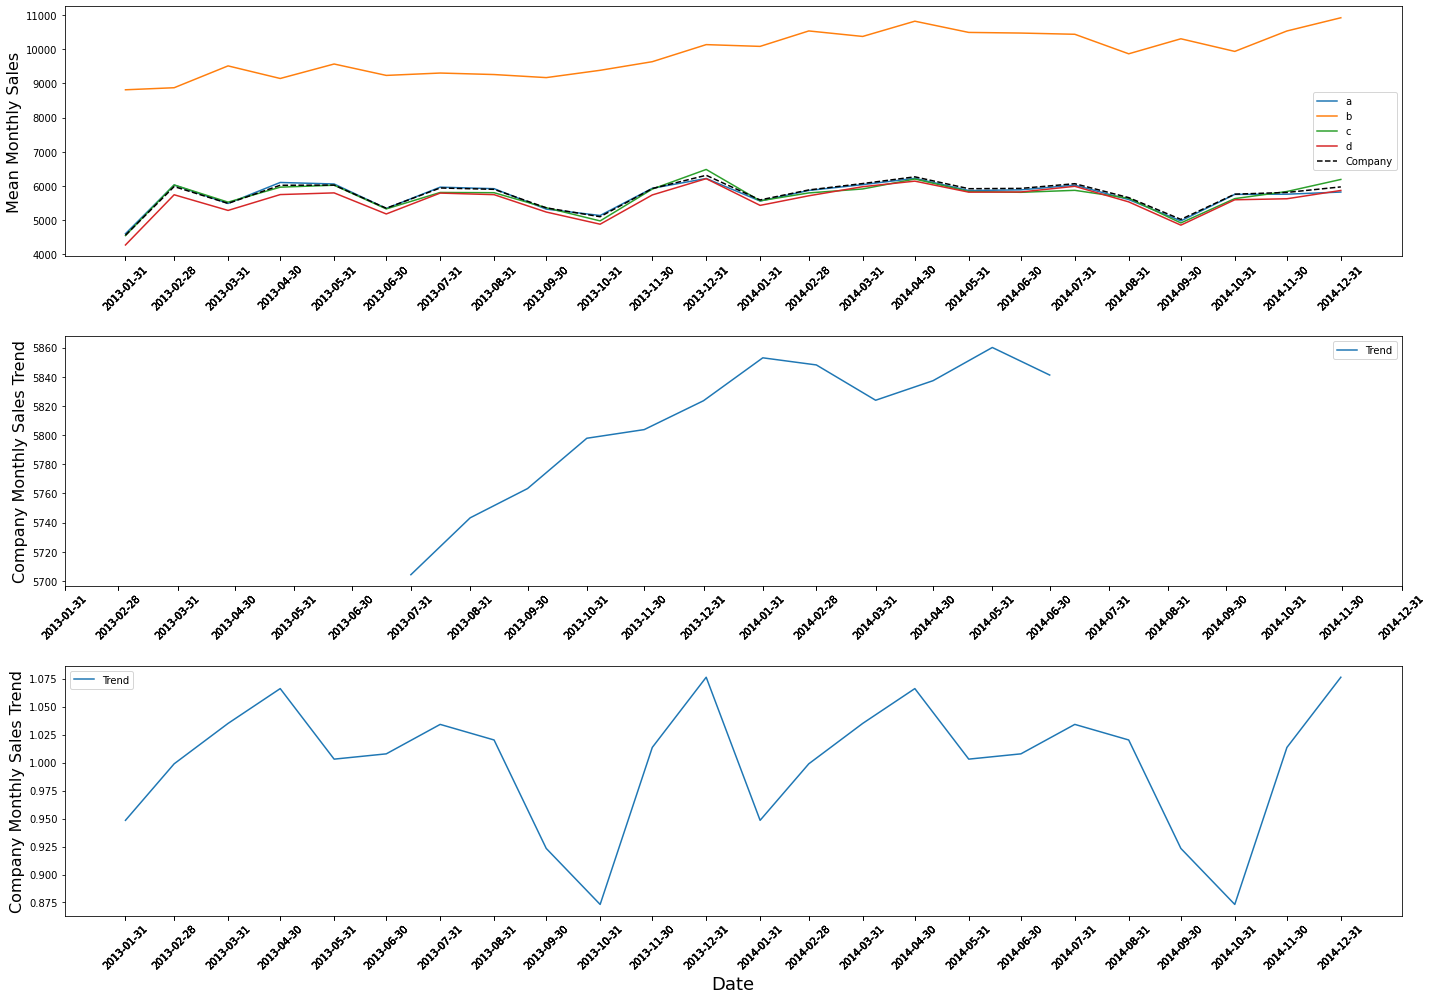

In [211]:
plt.figure(figsize=(20,14))

plt.subplot(3,1,1)
sns.lineplot(data=mean_company_sales, x = 'Date', y='Sales',hue='StoreType')
plt.plot(ts,label='Company',color='black',linestyle='--')
plt.xlabel('')
plt.ylabel('Mean Monthly Sales',fontsize=16)
plt.xticks(mean_company_sales['Date'],rotation=45)
plt.legend()

plt.subplot(3,1,2)
plt.plot(res.trend,label='Trend')
plt.ylabel('Company Monthly Sales Trend',fontsize=16)
plt.xticks(mean_company_sales['Date'],rotation=45)
plt.xlabel(' ')
plt.legend()
plt.tight_layout()

plt.subplot(3,1,3)
plt.plot(res.seasonal,label='Trend')
plt.ylabel('Company Monthly Sales Trend',fontsize=16)
plt.xticks(mean_company_sales['Date'],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.legend()
plt.tight_layout()

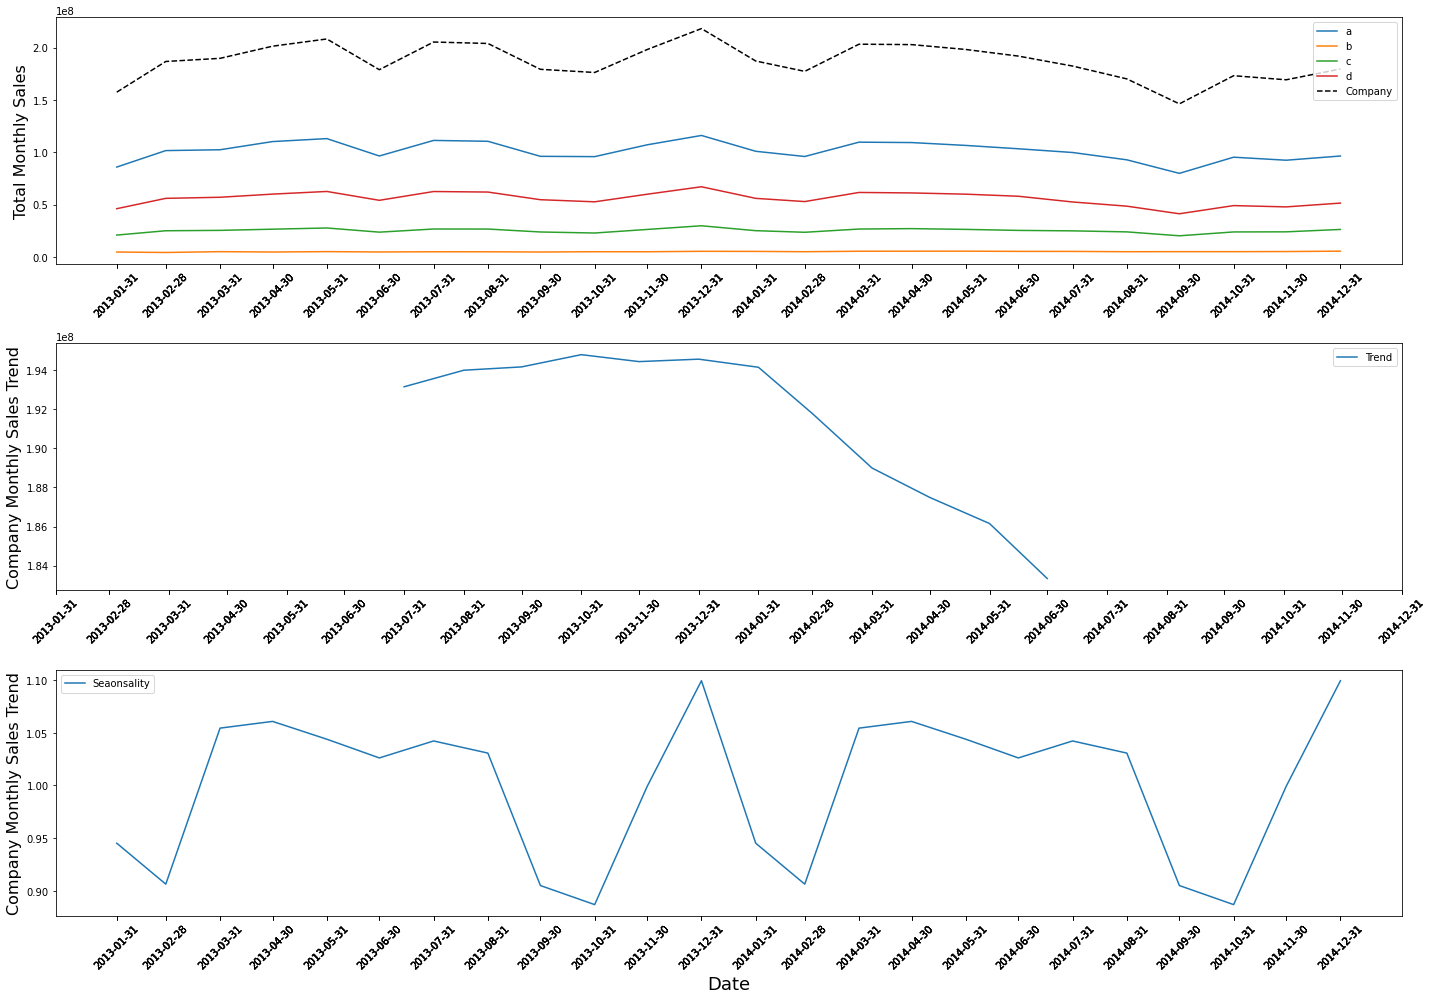

In [218]:
plt.figure(figsize=(20,14))

plt.subplot(3,1,1)
sns.lineplot(data=total_company_sales, x = 'Date', y='Sales',hue='StoreType')
plt.ylabel('Total Monthly Sales',fontsize=16)
plt.xticks(total_company_sales['Date'],rotation=45)
plt.plot(ts_sum,label='Company',color='black',linestyle='--')
plt.xlabel('')
plt.legend()

plt.subplot(3,1,2)

plt.plot(res2.trend,label='Trend')
plt.ylabel('Company Monthly Sales Trend',fontsize=16)
plt.xticks(total_company_sales['Date'],rotation=45)
plt.xlabel(' ')
plt.legend()

plt.subplot(3,1,3)

plt.plot(res2.seasonal,label='Seaonsality')
plt.ylabel('Company Monthly Sales Trend',fontsize=16)
plt.xticks(mean_company_sales['Date'],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.legend()


plt.tight_layout()



In [41]:
mean_company_sales['Month'] = mean_company_sales['Month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

<AxesSubplot:xlabel='Month', ylabel='Sales'>

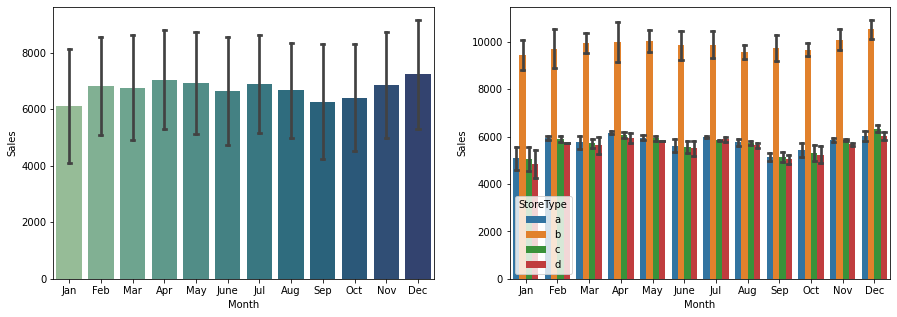

In [42]:
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.barplot(data=mean_company_sales, x = 'Month', y = 'Sales',ci='sd', capsize =.1,palette="crest")
plt.subplot(1,2,2)
sns.barplot(data=mean_company_sales, x = 'Month', y = 'Sales', hue='StoreType',ci = 'sd', capsize =.1)

In [43]:
#checking sales on days not open 
trainData['Sales'][trainData['Open'] == 0].sum()

0

In [44]:
#copy data before removing unopen days 
all_data = traindata_merge.copy()

In [45]:
#adding month data due to clear trend in EDA 
traindata_merge['Month'] = pd.DatetimeIndex(traindata_merge['Date']).month

#converting values into meaningful headers to produce dummy variables for regression. 
traindata_merge['DayOfWeek'] = traindata_merge['DayOfWeek'].replace({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})
traindata_merge['StateHoliday'] = traindata_merge['StateHoliday'].replace({'0':'None','a':'PH','b':'EH','c':'Xmas', 0:'None'})
traindata_merge['PromoInterval'] = traindata_merge['PromoInterval'].replace({0:'None'})
traindata_merge['Month'] = traindata_merge['Month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

Text(0, 0.5, 'Average Daily Sales 2013-2015')

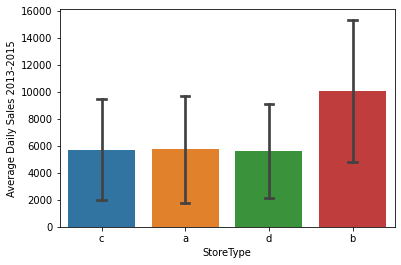

In [46]:
#looking at relationship between store type and sales 
sns.barplot(data=traindata_merge, x = 'StoreType', y = 'Sales',ci='sd', capsize =.1)
plt.ylabel('Average Daily Sales 2013-2015')

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Average Daily Sales'>

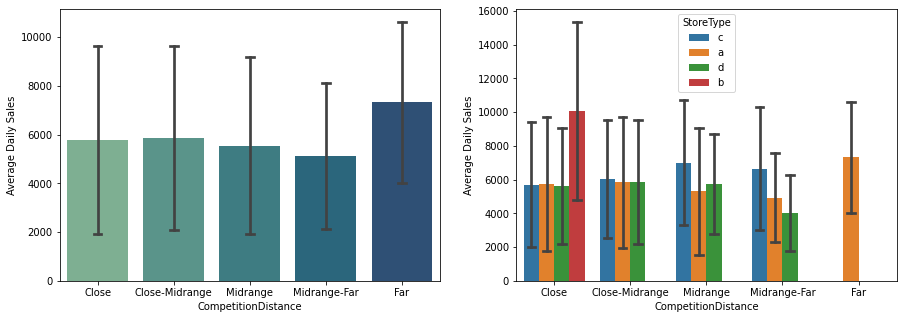

In [47]:
#looking at relationship between competition distance and sales 
competition = pd.cut(traindata_merge['CompetitionDistance'], bins = 5, labels = ['Close','Close-Midrange','Midrange','Midrange-Far','Far'])
sales_vs_competition = traindata_merge[['Sales','CompetitionDistance','StoreType']]
sales_vs_competition = sales_vs_competition.rename(columns = {'Sales':'Average Daily Sales'})

sales_vs_competition['CompetitionDistance'] = competition

fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.barplot(data=sales_vs_competition, x = 'CompetitionDistance', y = 'Average Daily Sales',ci='sd', capsize =.1,palette="crest")
plt.subplot(1,2,2)
sns.barplot(data=sales_vs_competition, x = 'CompetitionDistance', y = 'Average Daily Sales', hue='StoreType',ci='sd', capsize =.1)

<AxesSubplot:xlabel='PromoInterval', ylabel='Sales'>

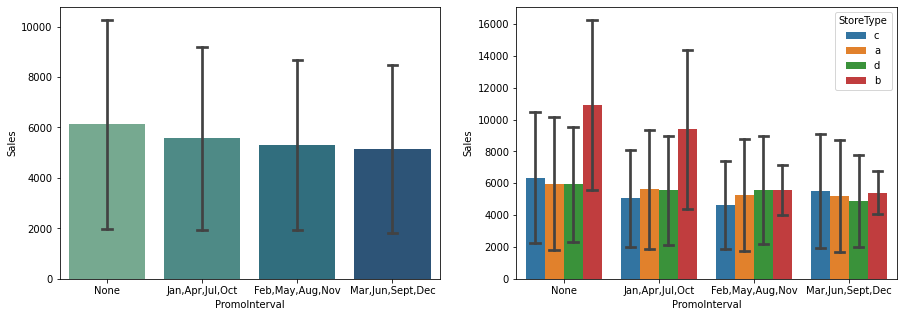

In [48]:
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.barplot(data=traindata_merge, x = 'PromoInterval', y = 'Sales',ci='sd', capsize =.1,palette='crest')
plt.subplot(1,2,2)
sns.barplot(data=traindata_merge, x = 'PromoInterval', y = 'Sales', hue='StoreType',ci='sd', capsize =.1)

<ipython-input-49-ccd2a65017b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo_vs_promo2['PromoCombination'] = np.select([m,m1,m2,m3],['Promo1_Only','Promo2_Only','No_Promotion','Both'],default=0)


<AxesSubplot:xlabel='PromoCombination', ylabel='Sales'>

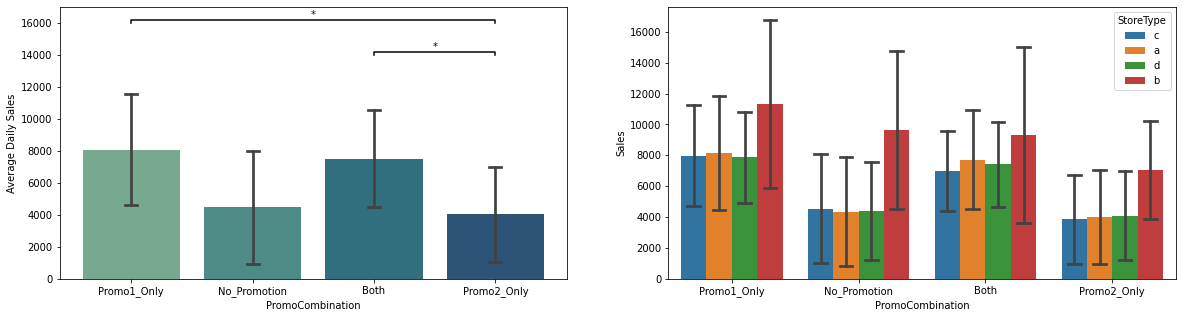

In [49]:
promo_vs_promo2 = traindata_merge[['Store','Sales','Promo','Promo2','StoreType','Month']]

m = (promo_vs_promo2['Promo']==1) & (promo_vs_promo2['Promo2'] == 0 )
m1 = (promo_vs_promo2['Promo']==0) & (promo_vs_promo2['Promo2'] == 1 )
m2 = (promo_vs_promo2['Promo']==0) & (promo_vs_promo2['Promo2'] == 0 )
m3 = (promo_vs_promo2['Promo']== 1) & (promo_vs_promo2['Promo2'] == 1 )

promo_vs_promo2['PromoCombination'] = np.select([m,m1,m2,m3],['Promo1_Only','Promo2_Only','No_Promotion','Both'],default=0)


promo_vs_promo2 = promo_vs_promo2.drop(['Promo','Promo2'],axis=1)

fig = plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.barplot(data=promo_vs_promo2, x='PromoCombination',y='Sales',ci='sd', capsize =.1,palette='crest')
x1, x2, x3 = 3, 2, 0   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, y1, h, col = 14000, 16000, 200, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.plot([x1, x1, x3, x3], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.text((x1+x3)*.5, y1+h, "*", ha='center', va='bottom', color=col)
plt.ylabel('Average Daily Sales')
plt.subplot(1,2,2)
sns.barplot(data=promo_vs_promo2, x='PromoCombination',y='Sales',hue = 'StoreType',ci='sd', capsize =.1)


<AxesSubplot:xlabel='Month', ylabel='Sales'>

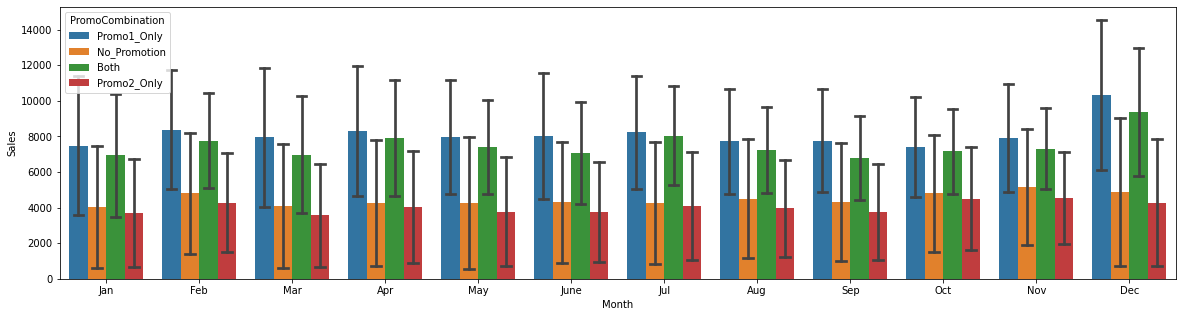

In [50]:
fig = plt.figure(figsize = (20,5))

sns.barplot(data=promo_vs_promo2, x='Month',y='Sales', hue = 'PromoCombination',order = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec'], ci='sd', capsize =.1) 

Text(0, 0.5, 'Average Daily Sales')

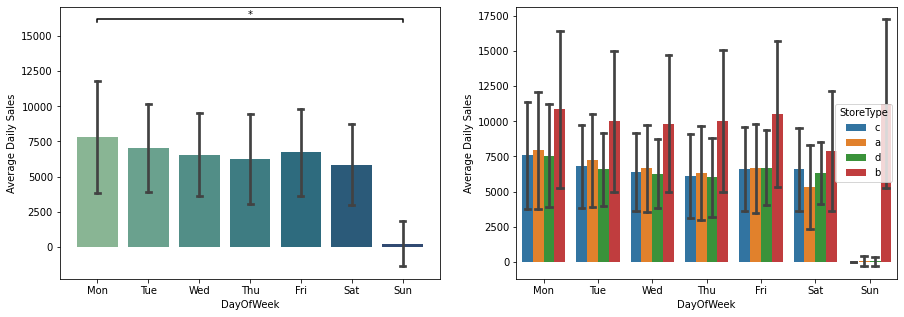

In [51]:
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.barplot(data=traindata_merge, x='DayOfWeek',y='Sales',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],ci='sd', capsize =.1,palette='crest')
x1, x2 = 6, 0   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 16000, 200, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.ylabel('Average Daily Sales')
plt.subplot(1,2,2)
sns.barplot(data=traindata_merge, x='DayOfWeek',y='Sales',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],hue='StoreType',ci='sd', capsize =.1)
plt.ylabel('Average Daily Sales')

Text(0, 0.5, 'Average Daily Sales')

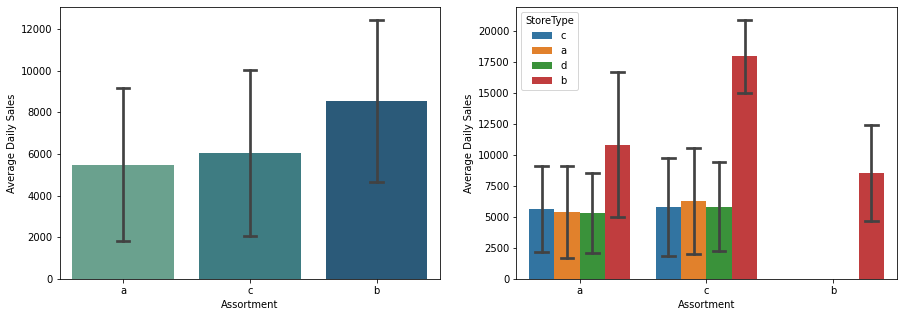

In [52]:

fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
sns.barplot(data=traindata_merge, x='Assortment',y='Sales',ci='sd', capsize =.1,palette='crest')

plt.ylabel('Average Daily Sales')
plt.subplot(1,2,2)
sns.barplot(data=traindata_merge, x='Assortment',y='Sales',hue = 'StoreType',ci='sd', capsize =.1)
plt.ylabel('Average Daily Sales')

Predicting Sales 

In [53]:
#will only be predicting store sales when stores are open, sales will be zero when stores are closed
traindata_merge = traindata_merge[traindata_merge["Open"]==1]
traindata_merge = traindata_merge.drop(['Open'],axis=1)

In [54]:
print (traindata_merge.StateHoliday.unique())
print (traindata_merge.PromoInterval.unique())
print(traindata_merge.DayOfWeek.unique())

['None' 'PH' 'EH' 'Xmas']
['None' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
['Fri' 'Thu' 'Wed' 'Tue' 'Mon' 'Sat' 'Sun']


In [55]:
#converting to dummy variables for regresssion
train_with_dummies = pd.get_dummies(traindata_merge)
train_with_dummies = train_with_dummies.set_index('Date')

<AxesSubplot:>

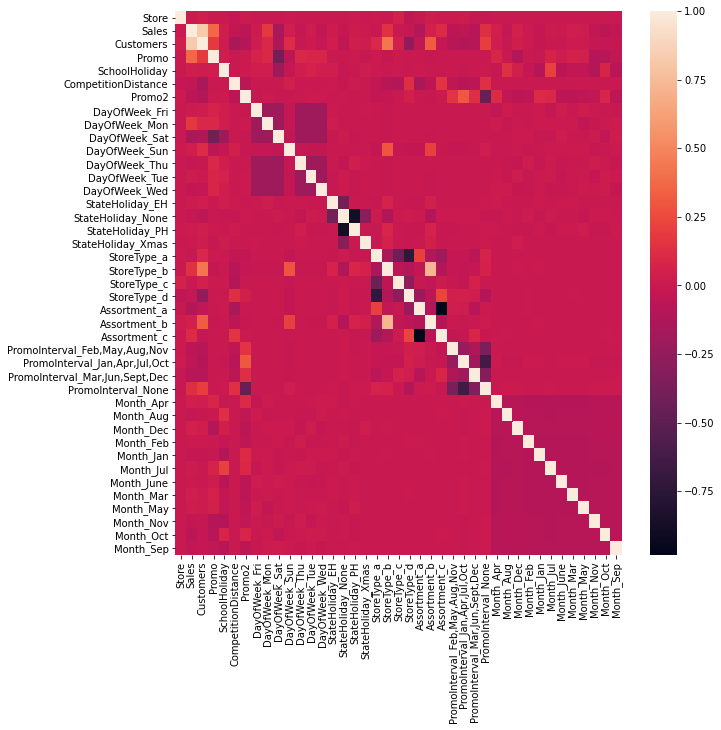

In [56]:
correlation_matrix = train_with_dummies.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix)

In [57]:
#remove variables from train_data that dont appear in test data
train_with_dummies = train_with_dummies.drop(['StateHoliday_EH','StateHoliday_Xmas','Customers','Store'],axis = 1)
train_with_dummies = train_with_dummies.reindex(sorted(train_with_dummies.columns), axis=1)

In [58]:
train_with_dummies.columns

Index(['Assortment_a', 'Assortment_b', 'Assortment_c', 'CompetitionDistance',
       'DayOfWeek_Fri', 'DayOfWeek_Mon', 'DayOfWeek_Sat', 'DayOfWeek_Sun',
       'DayOfWeek_Thu', 'DayOfWeek_Tue', 'DayOfWeek_Wed', 'Month_Apr',
       'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul',
       'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Promo', 'Promo2', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'PromoInterval_None', 'Sales', 'SchoolHoliday', 'StateHoliday_None',
       'StateHoliday_PH', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d'],
      dtype='object')

In [59]:
y = scale(train_with_dummies['Sales'])
X = scale(train_with_dummies.drop(['Sales'],axis=1))

In [60]:
y_mean = np.mean(train_with_dummies['Sales'])
y_std = np.std(train_with_dummies['Sales'])

In [61]:
kf = KFold(n_splits=10)

lambdas = [0.001,0.005,0.008,0.01,0.02]
mse_means = []

for lam in lambdas:
    
    test_mse = []
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = linear_model.Lasso(alpha=lam, fit_intercept = False, max_iter=1e5, selection = 'random')
        clf.fit(X_train,y_train)
        
        y_pred = clf.predict(X_test)
        
        test_mse.append(np.mean(np.square(y_pred-y_test)))
        
        mean_lam_mse = np.mean(test_mse)
        
    mse_means.append(np.mean(mean_lam_mse))


In [62]:
print(dict(zip(lambdas , mse_means)))
print("Optimised Lambda {}, Mean MSE from 10-KFold Cross Validation {}".format(lambdas[np.argmin(mse_means)], np.min(mse_means)))

{0.001: 0.7843906236134386, 0.005: 0.7850445054792365, 0.008: 0.785896983489514, 0.01: 0.7863456299684382, 0.02: 0.7916380257349471}
Optimised Lambda 0.001, Mean MSE from 10-KFold Cross Validation 0.7843906236134386


Model 2- Adding Previous year Sales to data model

In [187]:
model_2 = all_data.set_index('Date')

In [188]:
#getting 2013 data
data_2013 = model_2.loc["2013-01-01":"2013-12-31"] 

#get months and days to link back to 2015 data 
data_2013['Month'] = pd.DatetimeIndex(data_2013.index).month
data_2013['Day'] = pd.DatetimeIndex(data_2013.index).day

#get relevant predictors only 
data_2013 = data_2013[['Store','Sales','Month','Day']]
data_2013 = data_2013.rename(columns={'Sales':'Sales_2013'})

#get monthly averages for each store fot hotdeck imputation
data_2013_store_sales = data_2013.groupby(['Store','Month'])['Sales_2013'].mean().reset_index()
data_2013_store_sales =  data_2013_store_sales.rename(columns={'Sales_2013':'Sales_2013_Month_Average'})

#filling not open day sales with mean for that store for that month
data_2013['Sales_2013'][data_2013['Sales_2013']== 0] = np.nan

#merge monthly average data with 2013 data for hotdeck imputation 
data_2013 = data_2013.merge(data_2013_store_sales, how = 'left', on = ['Store','Month'])

#hotdeck imputation 
data_2013['Sales_2013'] = data_2013['Sales_2013'].fillna(data_2013['Sales_2013_Month_Average']).round(2)


In [189]:
data_2013

,Store,Sales_2013,Month,Day,Sales_2013_Month_Average
0,1,2362.00,12,31,4542.161290
1,1,7193.00,12,30,4542.161290
2,1,4542.16,12,29,4542.161290
3,1,5659.00,12,28,4542.161290
4,1,6110.00,12,27,4542.161290
...,...,...,...,...,...
406969,1115,4771.00,5,1,4836.032258
406970,1115,4540.00,4,1,4694.133333
406971,1115,4297.00,3,1,4701.580645
406972,1115,3697.00,2,1,4868.071429


In [190]:
data_2013.isnull().sum()

Store                       0
Sales_2013                  0
Month                       0
Day                         0
Sales_2013_Month_Average    0
dtype: int64

In [191]:
#hotdeck imputation for 2014
data_2014 = model_2.loc["2014-01-01":"2014-12-31"]

data_2014['Month'] = pd.DatetimeIndex(data_2014.index).month
data_2014['Day'] = pd.DatetimeIndex(data_2014.index).day

data_2014 = data_2014[['Store','Sales','Month','Day']]
data_2014 = data_2014.rename(columns={'Sales':'Sales_2014'})

data_2014_store_sales = data_2014.groupby(['Store','Month'])['Sales_2014'].mean().reset_index()
data_2014_store_sales =  data_2014_store_sales.rename(columns={'Sales_2014':'Sales_2014_Month_Average'})

data_2014 = data_2014.merge(data_2014_store_sales, how = 'left', on = ['Store','Month'])

data_2014['Sales_2014'][data_2014['Sales_2014']==0] = np.nan

data_2014['Sales_2014'] = data_2014['Sales_2014'].fillna(data_2014['Sales_2014_Month_Average']).round(2)


<ipython-input-191-7db2be267689>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2014['Sales_2014'][data_2014['Sales_2014']==0] = np.nan


In [192]:
data_2014.isnull().sum()

Store                       0
Sales_2014                  0
Month                       0
Day                         0
Sales_2014_Month_Average    0
dtype: int64

In [199]:
data_2015 = model_2.loc["2015-01-01":"2015-12-31"]

data_2015['Month'] = pd.DatetimeIndex(data_2015.index).month
data_2015['Day'] = pd.DatetimeIndex(data_2015.index).day

_2015_2014 = data_2015.merge(data_2014,how='left', on= ['Store','Month','Day'])

In [200]:
data_2015

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Month,Day
Date,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,0,0,7,31
2015-07-30,1,4,5020,546,1,1,0,1,c,a,1270.0,0,0,7,30
2015-07-29,1,3,4782,523,1,1,0,1,c,a,1270.0,0,0,7,29
2015-07-28,1,2,5011,560,1,1,0,1,c,a,1270.0,0,0,7,28
2015-07-27,1,1,6102,612,1,1,0,1,c,a,1270.0,0,0,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-01,1115,1,9102,580,1,1,0,1,d,c,5350.0,0,"Mar,Jun,Sept,Dec",5,1
2015-04-01,1115,7,0,0,0,0,0,1,d,c,5350.0,0,"Mar,Jun,Sept,Dec",4,1
2015-03-01,1115,6,6468,469,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",3,1


In [206]:
_2015_2014[_2015_2014['Sales_2014'].isnull()]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Month,Day,Sales_2014,Sales_2014_Month_Average
2544,13,5,8821,568,1,1,0,0,d,a,310.0,0,"Feb,May,Aug,Nov",7,31,NaN,NaN
2545,13,4,7648,474,1,1,0,0,d,a,310.0,0,"Feb,May,Aug,Nov",7,30,NaN,NaN
2546,13,3,6648,406,1,1,0,0,d,a,310.0,0,"Feb,May,Aug,Nov",7,29,NaN,NaN
2547,13,2,6819,446,1,1,0,0,d,a,310.0,0,"Feb,May,Aug,Nov",7,28,NaN,NaN
2548,13,1,7926,527,1,1,0,0,d,a,310.0,0,"Feb,May,Aug,Nov",7,27,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234922,1109,7,0,0,0,0,0,0,c,a,3490.0,0,"Jan,Apr,Jul,Oct",5,7,NaN,NaN
234923,1109,6,3537,322,1,0,0,0,c,a,3490.0,1,"Jan,Apr,Jul,Oct",4,7,NaN,NaN
234924,1109,5,5181,494,1,1,0,0,c,a,3490.0,0,"Jan,Apr,Jul,Oct",3,7,NaN,NaN
234925,1109,4,4313,424,1,1,0,0,c,a,3490.0,0,"Jan,Apr,Jul,Oct",2,7,NaN,NaN


In [207]:
data_2014[data_2014['Store'] == 13]

,Store,Sales_2014,Month,Day,Sales_2014_Month_Average
4380,13,9192.00,6,30,3975.208333
4381,13,3975.21,6,29,3975.208333
4382,13,4455.00,6,28,3975.208333
4383,13,4376.00,6,27,3975.208333
4384,13,3165.00,6,26,3975.208333
...,...,...,...,...,...
4556,13,4032.08,5,1,4032.080000
4557,13,4681.00,4,1,4653.208333
4558,13,3629.00,3,1,4416.920000
4559,13,4092.00,2,1,3962.090909


In [202]:
_2015_2014.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                          0
Customers                      0
Open                           0
Promo                          0
StateHoliday                   0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
CompetitionDistance            0
Promo2                         0
PromoInterval                  0
Month                          0
Day                            0
Sales_2014                  5580
Sales_2014_Month_Average    5580
dtype: int64

In [203]:
model_2_merge = _2015_2014.merge(data_2013, how ='left', on = ['Store','Month','Day'])

In [204]:
model_2_merge.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                          0
Customers                      0
Open                           0
Promo                          0
StateHoliday                   0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
CompetitionDistance            0
Promo2                         0
PromoInterval                  0
Month                          0
Day                            0
Sales_2014                  5580
Sales_2014_Month_Average    5580
Sales_2013                     1
Sales_2013_Month_Average       1
dtype: int64

In [177]:
model_2_merge

,Store,Sales_2014,Month,Day,Sales_2014_Month_Average,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Sales_2013,Sales_2013_Month_Average
0,1,5106.00,7,31,3986.677419,5,5263,555,1,1,0,1,c,a,1270.0,0,0,5572.00,4132.096774
1,1,5487.00,7,30,3986.677419,4,5020,546,1,1,0,1,c,a,1270.0,0,0,5773.00,4132.096774
2,1,5252.00,7,29,3986.677419,3,4782,523,1,1,0,1,c,a,1270.0,0,0,6290.00,4132.096774
3,1,5372.00,7,28,3986.677419,2,5011,560,1,1,0,1,c,a,1270.0,0,0,4132.10,4132.096774
4,1,3986.68,7,27,3986.677419,1,6102,612,1,1,0,1,c,a,1270.0,0,0,3352.00,4132.096774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230795,1115,5628.35,5,1,5628.354839,1,9102,580,1,1,0,1,d,c,5350.0,0,"Mar,Jun,Sept,Dec",4771.00,4836.032258
230796,1115,5586.00,4,1,5869.333333,7,0,0,0,0,0,1,d,c,5350.0,0,"Mar,Jun,Sept,Dec",4540.00,4694.133333
230797,1115,5050.00,3,1,5568.483871,6,6468,469,1,0,0,1,d,c,5350.0,1,"Mar,Jun,Sept,Dec",4297.00,4701.580645
230798,1115,5657.00,2,1,5349.857143,5,7558,539,1,0,0,1,d,c,5350.0,0,"Mar,Jun,Sept,Dec",3697.00,4868.071429


In [205]:
#select rows when stores are open 
model_2_merge = model_2_merge[model_2_merge.Open==1]

In [ ]:
model_2_merge[]

In [77]:
# fill sales 2014 sales values with 2013 values 
model_2_merge['Sales_2014'] = model_2_merge['Sales_2014'].fillna(model_2_merge['Sales_2013_Month_Average'])

<ipython-input-77-799f7e1c6cf4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_2_merge['Sales_2014'] = model_2_merge['Sales_2014'].fillna(model_2_merge['Sales_2013_Month_Average'])


In [78]:
model_2_merge.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                          0
Customers                      0
Open                           0
Promo                          0
StateHoliday                   0
SchoolHoliday                  0
StoreType                      0
Assortment                     0
CompetitionDistance            0
Promo2                         0
PromoInterval                  0
Month                          0
Day                            0
Sales_2014                     0
Sales_2014_Month_Average    4850
Sales_2013                     0
Sales_2013_Month_Average       0
dtype: int64

In [79]:
model_2_merge['DayOfWeek'] = model_2_merge['DayOfWeek'].replace({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})
model_2_merge['StateHoliday'] = model_2_merge['StateHoliday'].replace({'0':'None','a':'PH','b':'EH','c':'Xmas', 0:'None'})
model_2_merge['PromoInterval'] = model_2_merge['PromoInterval'].replace({0:'None','0':'None'})
model_2_merge['Month'] = model_2_merge['Month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'Jul',8:'Aug',9:'Sep',10:'Ocr',11:'Nov',12:'Dec'})

<ipython-input-79-76ce3441df1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_2_merge['DayOfWeek'] = model_2_merge['DayOfWeek'].replace({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})
<ipython-input-79-76ce3441df1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_2_merge['StateHoliday'] = model_2_merge['StateHoliday'].replace({'0':'None','a':'PH','b':'EH','c':'Xmas', 0:'None'})
<ipython-input-79-76ce3441df1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [80]:
model_2_dummies = pd.get_dummies(model_2_merge)

In [81]:
model_2_dummies

,Store,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Day,Sales_2014,...,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Ocr,Month_Sep
0,1,5263,555,1,1,1,1270.0,0,31,5106.00,...,0,0,0,1,0,0,0,0,0,0
1,1,5020,546,1,1,1,1270.0,0,30,5487.00,...,0,0,0,1,0,0,0,0,0,0
2,1,4782,523,1,1,1,1270.0,0,29,5252.00,...,0,0,0,1,0,0,0,0,0,0
3,1,5011,560,1,1,1,1270.0,0,28,5372.00,...,0,0,0,1,0,0,0,0,0,0
4,1,6102,612,1,1,1,1270.0,0,27,3986.68,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236373,1115,6615,389,1,1,1,5350.0,0,1,6242.00,...,0,0,0,1,0,0,0,0,0,0
236374,1115,7380,440,1,1,1,5350.0,1,1,8536.00,...,0,0,0,0,1,0,0,0,0,0
236375,1115,9102,580,1,1,1,5350.0,0,1,5628.35,...,0,0,0,0,0,0,1,0,0,0
236377,1115,6468,469,1,0,1,5350.0,1,1,5050.00,...,0,0,0,0,0,1,0,0,0,0


In [82]:
#drop customers, store numbers, 'day'
model_2_dummies = model_2_dummies.drop(['Store','Customers','Open','Day','Sales_2014_Month_Average','Sales_2013_Month_Average'],axis=1)

<AxesSubplot:>

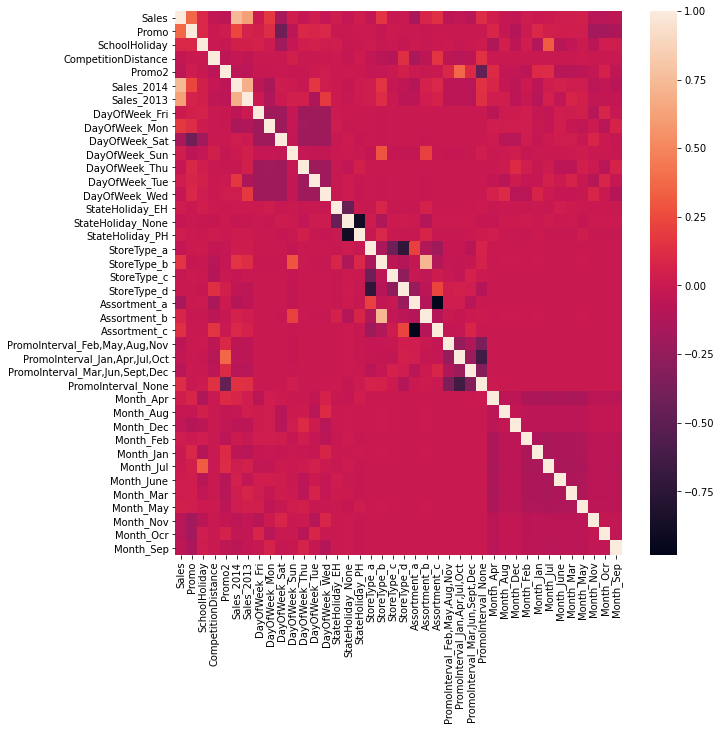

In [83]:
correlation_matrix = model_2_dummies.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix)

In [84]:
#ordering alphabetically
model_2_dummies = model_2_dummies.reindex(sorted(model_2_dummies.columns), axis=1)

In [85]:
#remove easter holiday dummy variable because it is not present in test dataset
model_2_dummies = model_2_dummies.drop(['StateHoliday_EH'],axis=1)

In [86]:
model_2_dummies

,Assortment_a,Assortment_b,Assortment_c,CompetitionDistance,DayOfWeek_Fri,DayOfWeek_Mon,DayOfWeek_Sat,DayOfWeek_Sun,DayOfWeek_Thu,DayOfWeek_Tue,...,Sales,Sales_2013,Sales_2014,SchoolHoliday,StateHoliday_None,StateHoliday_PH,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,1,0,0,1270.0,1,0,0,0,0,0,...,5263,5572.00,5106.00,1,1,0,0,0,1,0
1,1,0,0,1270.0,0,0,0,0,1,0,...,5020,5773.00,5487.00,1,1,0,0,0,1,0
2,1,0,0,1270.0,0,0,0,0,0,0,...,4782,6290.00,5252.00,1,1,0,0,0,1,0
3,1,0,0,1270.0,0,0,0,0,0,1,...,5011,4132.10,5372.00,1,1,0,0,0,1,0
4,1,0,0,1270.0,0,1,0,0,0,0,...,6102,3352.00,3986.68,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236373,0,0,1,5350.0,0,0,0,0,0,0,...,6615,6905.00,6242.00,1,1,0,0,0,0,1
236374,0,0,1,5350.0,0,0,0,0,0,1,...,7380,4361.07,8536.00,1,1,0,0,0,0,1
236375,0,0,1,5350.0,0,1,0,0,0,0,...,9102,4771.00,5628.35,1,1,0,0,0,0,1
236377,0,0,1,5350.0,0,0,1,0,0,0,...,6468,4297.00,5050.00,1,1,0,0,0,0,1


In [87]:
y1 = scale(model_2_dummies['Sales'])
X1 = scale(model_2_dummies.drop(['Sales'],axis=1))

In [88]:
y1_mean = np.mean(model_2_dummies['Sales'])
y1_std = np.std(model_2_dummies['Sales'])

In [89]:
kf = KFold(n_splits=10)

lambdas2 = [0.001,0.005,0.008,0.01,0.02]

mse_means1 = []

for lam in lambdas:
    
    test_mse1 = []
    
    for train_index, test_index in kf.split(X1):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = linear_model.Lasso(alpha=lam, fit_intercept = False, max_iter=1e5, selection = 'random')
        
        clf.fit(X_train,y_train)
        
        y_pred = clf.predict(X_test)
        
        test_mse1.append(np.mean(np.square(y_pred - y_test)))
        
    mean_lam_mse = np.mean(test_mse1)
        
    mse_means1.append(np.mean(mean_lam_mse))


In [90]:
print(dict(zip(lambdas2 , mse_means1)))
print("Optimised Lambda {}, Mean MSE from 10-KFold Cross Validation {}".format(lambdas[np.argmin(mse_means1)], np.min(mse_means1)))

{0.001: 0.7719845911174185, 0.005: 0.6125692502216288, 0.008: 0.6072173545552355, 0.01: 0.6038550963167928, 0.02: 0.6078894373924307}
Optimised Lambda 0.01, Mean MSE from 10-KFold Cross Validation 0.6038550963167928


Preparing test data

In [240]:
testData = pd.read_csv('./test.csv',dtype = {'7':np.int32})

In [241]:
#merging tables on storedata
testdata_merge = testData.merge(storeData, how = 'inner', on = 'Store')

testdata_merge['Date'] = pd.to_datetime(testdata_merge['Date'])

#creating Date Month column consisting of the month only to see if the store was participating in promo2 in a given month
testdata_merge['Date_Month'] = pd.DatetimeIndex(testdata_merge['Date']).month

#sort data by date
testdata_merge = testdata_merge.sort_values(by=['Date','Store'])


In [242]:
#updating promo2 column to show whether store was participating in Promo2 on a given day
m = (testdata_merge[0] == testdata_merge['Date_Month'])
m1 = (testdata_merge[1] == testdata_merge['Date_Month'])
m2 = (testdata_merge[2] == testdata_merge['Date_Month'])
m3 = (testdata_merge[3] == testdata_merge['Date_Month'])
testdata_merge['Promo2'] = np.select([m,m1,m2,m3],[1,1,1,1],default=0)
testdata_merge

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,Promo2,PromoInterval,Datetime_Comp,Promo_Datetime,0,1,2,3,Date_Month
47,1,6,2015-01-08,NaN,NaN,1.0,0,0,1,c,...,1270.0,0,0,2008-09-01,NaT,NaN,NaN,NaN,NaN,1
95,3,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,14130.0,1,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-04,1.0,4.0,7.0,10.0,1
143,7,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,24000.0,0,0,2013-04-01,NaT,NaN,NaN,NaN,NaN,1
191,8,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,7520.0,0,0,2014-10-01,NaT,NaN,NaN,NaN,NaN,1
239,9,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,2030.0,0,0,2000-08-01,NaT,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40853,1111,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,1900.0,0,"Jan,Apr,Jul,Oct",2014-06-01,2013-08-05,1.0,4.0,7.0,10.0,12
40901,1112,6,2015-12-09,NaN,NaN,1.0,0,0,0,c,...,1880.0,0,0,2006-04-01,NaT,NaN,NaN,NaN,NaN,12
40949,1113,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,9260.0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,12
40997,1114,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,870.0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,12


In [243]:
#checking consistency
testdata_merge[testdata_merge['Promo2'] ==1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,Promo2,PromoInterval,Datetime_Comp,Promo_Datetime,0,1,2,3,Date_Month
95,3,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,14130.0,1,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-04,1.0,4.0,7.0,10.0,1
335,11,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,960.0,1,"Jan,Apr,Jul,Oct",2011-11-01,2012-01-02,1.0,4.0,7.0,10.0,1
383,12,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,1070.0,1,"Jan,Apr,Jul,Oct",NaT,2010-03-29,1.0,4.0,7.0,10.0,1
479,14,6,2015-01-08,NaN,NaN,1.0,0,0,0,a,...,1300.0,1,"Jan,Apr,Jul,Oct",2014-03-01,2011-10-03,1.0,4.0,7.0,10.0,1
527,15,6,2015-01-08,NaN,NaN,1.0,0,0,0,d,...,4110.0,1,"Jan,Apr,Jul,Oct",2010-03-01,2011-04-04,1.0,4.0,7.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39221,1065,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,1290.0,1,"Mar,Jun,Sept,Dec",NaT,2011-08-29,3.0,6.0,9.0,12.0,12
39461,1071,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,820.0,1,"Mar,Jun,Sept,Dec",2012-03-01,2012-08-27,3.0,6.0,9.0,12.0,12
39653,1077,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,3750.0,1,"Mar,Jun,Sept,Dec",2001-11-01,2010-08-30,3.0,6.0,9.0,12.0,12
40277,1096,6,2015-12-09,NaN,NaN,1.0,0,0,0,a,...,1130.0,1,"Mar,Jun,Sept,Dec",NaT,2014-03-10,3.0,6.0,9.0,12.0,12


In [244]:
#dropping unneccessary columns
testdata_merge = testdata_merge.drop(['Datetime_Comp','Promo_Datetime','Datetime_Comp',0,1,2,3,'Promo_Datetime'],axis=1)

In [245]:
#converting values into meaningful headers to produce dummy variables for regression. 
testdata_merge['DayOfWeek'] = testdata_merge['DayOfWeek'].replace({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})
testdata_merge['StateHoliday'] = testdata_merge['StateHoliday'].replace({'0':'None','a':'PH','b':'EH','c':'Xmas', 0:'None'})
testdata_merge['PromoInterval'] = testdata_merge['PromoInterval'].replace({0:'None'})

#replacings 'Date Month' with 'Month' for consistency 
testdata_merge['Month'] = testdata_merge['Date_Month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'Jul',8:'Aug',9:'Sep',10:'Ocr',11:'Nov',12:'Dec'})
testdata_merge = testdata_merge.drop(['Date_Month'],axis=1)

In [246]:
test_with_dummies = pd.get_dummies(testdata_merge)
test_with_dummies = test_with_dummies.drop(['Customers'],axis=1)

In [247]:
test_with_dummies = test_with_dummies.set_index('Date')
test_with_dummies['Month'] = pd.DatetimeIndex(test_with_dummies.index).month
test_with_dummies['Day'] = pd.DatetimeIndex(test_with_dummies.index).day

In [248]:
#checking for na values
print(test_with_dummies.isnull().sum())

Store                                 0
Sales                             41088
Open                                 11
Promo                                 0
SchoolHoliday                         0
CompetitionDistance                   0
Promo2                                0
DayOfWeek_Fri                         0
DayOfWeek_Mon                         0
DayOfWeek_Sat                         0
DayOfWeek_Sun                         0
DayOfWeek_Thu                         0
DayOfWeek_Tue                         0
DayOfWeek_Wed                         0
StateHoliday_None                     0
StateHoliday_PH                       0
StoreType_a                           0
StoreType_b                           0
StoreType_c                           0
StoreType_d                           0
Assortment_a                          0
Assortment_b                          0
Assortment_c                          0
PromoInterval_Feb,May,Aug,Nov         0
PromoInterval_Jan,Apr,Jul,Oct         0


In [249]:
#looking at NaN values in Open column
test_with_dummies[~test_with_dummies['Open'].isin([0,1])]

,Store,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DayOfWeek_Fri,DayOfWeek_Mon,DayOfWeek_Sat,...,Month_Jan,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Ocr,Month_Sep,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-09,622,NaN,NaN,0,0,0.0,0,0,0,1,...,0,0,0,0,1,0,0,0,5,9
2015-07-09,622,NaN,NaN,0,0,0.0,0,0,1,0,...,0,1,0,0,0,0,0,0,7,9
2015-08-09,622,NaN,NaN,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,9
2015-09-09,622,NaN,NaN,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,9,9
2015-09-14,622,NaN,NaN,1,0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,9,14
2015-09-15,622,NaN,NaN,1,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,9,15
2015-09-16,622,NaN,NaN,1,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,9,16
2015-09-17,622,NaN,NaN,1,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,9,17
2015-10-09,622,NaN,NaN,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,10,9


In [250]:
#assumed stores were open on this day based on other columns, ie no  public holiday, store type is a 
test_with_dummies['Open'][~test_with_dummies['Open'].isin([0,1])] = 1

<ipython-input-250-b8d5ecbaa354>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_with_dummies['Open'][~test_with_dummies['Open'].isin([0,1])] = 1


In [251]:
#merge with corresponding dates from 2013
test_dummies_merge = test_with_dummies.merge(data_2013,how='left', on = ['Store','Month','Day'])

#no new NaN values added 
test_dummies_merge.isnull().sum()

Store                                 0
Sales                             41088
Open                                  0
Promo                                 0
SchoolHoliday                         0
CompetitionDistance                   0
Promo2                                0
DayOfWeek_Fri                         0
DayOfWeek_Mon                         0
DayOfWeek_Sat                         0
DayOfWeek_Sun                         0
DayOfWeek_Thu                         0
DayOfWeek_Tue                         0
DayOfWeek_Wed                         0
StateHoliday_None                     0
StateHoliday_PH                       0
StoreType_a                           0
StoreType_b                           0
StoreType_c                           0
StoreType_d                           0
Assortment_a                          0
Assortment_b                          0
Assortment_c                          0
PromoInterval_Feb,May,Aug,Nov         0
PromoInterval_Jan,Apr,Jul,Oct         0


In [252]:
#merging with 2014 data
test_dummies_merge = test_dummies_merge.merge(data_2014,how ='left', on = ['Store','Month','Day'])

print(test_dummies_merge.isnull().sum())

# imputation of mean daily sales for a given store on a given month in 2013
test_dummies_merge['Sales_2014'] = test_dummies_merge['Sales_2014'].fillna(test_dummies_merge['Sales_2013_Month_Average']).round(2)


Store                                 0
Sales                             41088
Open                                  0
Promo                                 0
SchoolHoliday                         0
CompetitionDistance                   0
Promo2                                0
DayOfWeek_Fri                         0
DayOfWeek_Mon                         0
DayOfWeek_Sat                         0
DayOfWeek_Sun                         0
DayOfWeek_Thu                         0
DayOfWeek_Tue                         0
DayOfWeek_Wed                         0
StateHoliday_None                     0
StateHoliday_PH                       0
StoreType_a                           0
StoreType_b                           0
StoreType_c                           0
StoreType_d                           0
Assortment_a                          0
Assortment_b                          0
Assortment_c                          0
PromoInterval_Feb,May,Aug,Nov         0
PromoInterval_Jan,Apr,Jul,Oct         0


In [253]:
# imputation of mean daily sales for a given store on a given month in 2013
test_dummies_merge['Sales_2014'] = test_dummies_merge['Sales_2014'].fillna(test_dummies_merge['Sales_2013_Month_Average']).round(2)

In [254]:
#dropping unnessary columns 
test_dummies_merge = test_dummies_merge.drop(['Store','Sales','Day','Month','Sales_2013_Month_Average','Sales_2014_Month_Average',],axis=1)

#creating separate dataframe of dates when stores arent open to join later 
test_data_not_open = test_with_dummies[test_with_dummies['Open']==0]

#will only be predicting store sales when stores are open, sales will be zero when stores are closed
test_dummies_merge = test_dummies_merge[test_dummies_merge["Open"]==1]

#drop open column                                              
test_dummies_merge = test_dummies_merge.drop(['Open'],axis=1)


In [255]:
#ordering alphabetically
test_dummies_merge = test_dummies_merge.reindex(sorted(test_dummies_merge.columns), axis=1)

In [235]:
len(test_dummies_merge.columns)

38

In [236]:
len(model_2_dummies.columns)

39

In [237]:
# using model 2 
lasso_reg = linear_model.Lasso(alpha=0.01,max_iter=1e5, selection = 'random')
lasso_reg.fit(X1,y1)

Lasso(alpha=0.01, max_iter=100000.0, selection='random')

In [261]:
# getting weightings of indicators
coefficients = list(model_2_dummies.columns)
coefficients.remove('Sales')

predictor_weightings = pd.DataFrame(lasso_reg.coef_,index=coefficients,columns=['Weighting']).round(2)

#get predictors which have not been shrunk 
predictor_weightings = predictor_weightings[predictor_weightings['Weighting']!=0]

#sort predictors
predictor_weightings = predictor_weightings.reindex(predictor_weightings.Weighting.abs().sort_values(ascending=False).index)

predictor_weightings

,Weighting
Sales_2014,0.55
DayOfWeek_Mon,0.26
Sales_2013,0.24
Promo,0.17
Assortment_a,-0.06
DayOfWeek_Fri,0.05
Month_Jan,0.04
DayOfWeek_Wed,-0.03
StoreType_b,0.03
SchoolHoliday,0.03


In [239]:
#predicting sales of test data 
y_pred = lasso_reg.predict(test_dummies_merge)
len(y_pred)

35104

In [110]:
#getting original data with dates on days when stores were open 
test_with_dummies_open = test_with_dummies[test_with_dummies['Open']==1]

In [111]:
test_with_dummies_open['Sales'] = y_pred

<ipython-input-111-dad144947f71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_with_dummies_open['Sales'] = y_pred


In [112]:
test_with_dummies_open = test_with_dummies_open.reset_index()

In [113]:
test_with_dummies_open

,Date,Store,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DayOfWeek_Fri,DayOfWeek_Mon,...,Month_Jan,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Ocr,Month_Sep,Month,Day
0,2015-01-08,1,3975.850769,1.0,0,1,1270.0,0,0,0,...,1,0,0,0,0,0,0,0,1,8
1,2015-01-08,3,6389.909228,1.0,0,0,14130.0,1,0,0,...,1,0,0,0,0,0,0,0,1,8
2,2015-01-08,7,9495.034212,1.0,0,0,24000.0,0,0,0,...,1,0,0,0,0,0,0,0,1,8
3,2015-01-08,8,5090.137501,1.0,0,0,7520.0,0,0,0,...,1,0,0,0,0,0,0,0,1,8
4,2015-01-08,9,6163.808079,1.0,0,0,2030.0,0,0,0,...,1,0,0,0,0,0,0,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35099,2015-12-09,1111,4034.865410,1.0,0,0,1900.0,0,0,0,...,0,0,0,0,0,0,0,0,12,9
35100,2015-12-09,1112,7173.010187,1.0,0,0,1880.0,0,0,0,...,0,0,0,0,0,0,0,0,12,9
35101,2015-12-09,1113,4489.868174,1.0,0,0,9260.0,0,0,0,...,0,0,0,0,0,0,0,0,12,9
35102,2015-12-09,1114,15778.612997,1.0,0,0,870.0,0,0,0,...,0,0,0,0,0,0,0,0,12,9


In [114]:
#assigning days not open with no sales 
test_data_not_open['Sales'][test_data_not_open['Open']==0] = 0

<ipython-input-114-50968425c898>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_not_open['Sales'][test_data_not_open['Open']==0] = 0
/home/elia/.local/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [115]:
test_data_not_open = test_data_not_open.reset_index()

In [116]:
predictions = pd.concat([test_data_not_open , test_with_dummies_open], ignore_index=True)

predictions = predictions.sort_values(by=['Date','Store'])

#get original storedata back
predictions = predictions.rename(columns={'StoreType_a':'a','StoreType_b':'b','StoreType_c':'c','StoreType_d':'d'})
stores = predictions[['a','b','c','d']].stack()
stores = pd.Categorical(stores[stores!=0].index.get_level_values(1))
predictions['StoreType'] = stores
predictions['Predicted'] = np.repeat('Yes',predictions.shape[0])

predictions_stores = predictions[['Date','Store','Sales','Predicted','StoreType']]
predictions = predictions.set_index('Date')

In [117]:
predictions

,Store,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,DayOfWeek_Fri,DayOfWeek_Mon,DayOfWeek_Sat,...,Month_June,Month_Mar,Month_May,Month_Nov,Month_Ocr,Month_Sep,Month,Day,StoreType,Predicted
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-08,1,3975.850769,1.0,0,1,1270.0,0,0,0,1,...,0,0,0,0,0,0,1,8,c,Yes
2015-01-08,3,6389.909228,1.0,0,0,14130.0,1,0,0,1,...,0,0,0,0,0,0,1,8,a,Yes
2015-01-08,7,9495.034212,1.0,0,0,24000.0,0,0,0,1,...,0,0,0,0,0,0,1,8,a,Yes
2015-01-08,8,5090.137501,1.0,0,0,7520.0,0,0,0,1,...,0,0,0,0,0,0,1,8,a,Yes
2015-01-08,9,6163.808079,1.0,0,0,2030.0,0,0,0,1,...,0,0,0,0,0,0,1,8,a,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-09,1111,4034.865410,1.0,0,0,1900.0,0,0,0,1,...,0,0,0,0,0,0,12,9,a,Yes
2015-12-09,1112,7173.010187,1.0,0,0,1880.0,0,0,0,1,...,0,0,0,0,0,0,12,9,c,Yes
2015-12-09,1113,4489.868174,1.0,0,0,9260.0,0,0,0,1,...,0,0,0,0,0,0,12,9,a,Yes


In [118]:
data_2015_stores_sales = data_2015.reset_index()
data_2015_stores_sales = data_2015_stores_sales[['Date','Store','Sales','StoreType']]

In [119]:
complete_2015_data = pd.concat([data_2015_stores_sales, predictions_stores],ignore_index=True)

<AxesSubplot:xlabel='Date', ylabel='Sales'>

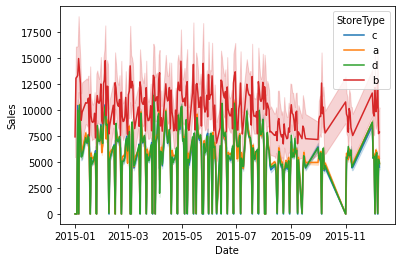

In [120]:
sns.lineplot(data=complete_2015_data, x='Date', y= 'Sales', hue = 'StoreType')

In [121]:
1115/1476

0.755420054200542